# Value-based vision agent in the tetris environment using PyTorch

|        | TYPE                   | VALUES          | DESCRIPTION                                                                                                |
|--------|------------------------|-----------------|------------------------------------------------------------------------------------------------------------|
| Action Space | ndarray<br/>(1,) | {0, 1, 2, 3, 4} | Action to manipulate the current tile.<br/>0: No action<br/>1: Rotate<br/>2: Right<br/>3: Left<br/>4: Down |
| Observation Space | ndarray<br/>(210,160) | <0, 255> | The game screen. |
| Reward |  | float | Reward given when a row is filled.<br/>Single: 1<br/>Double: 3<br/>Triple: 8<br/>Quadruple: 18       |
| Termination |  | boolean | The game ends when the pieces stack up to the top of the playing field.                                    |

In [1]:
import copy
import time
import torch
import imageio
import gymnasium as gym
import matplotlib.pyplot as plt

from agents.value_video import VideoDeepQ

In [2]:
environment = gym.make('ALE/Tetris-v5', render_mode="rgb_array", obs_type="grayscale",
                       frameskip=1, repeat_action_probability=0.0)
environment.metadata['render_fps'] = 30

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


### Training

#### Parameters

In [3]:
GAMES = 300
FRAMESKIP = 4                                               # Repeat action for n frames

DISCOUNT = 0.99                                             # Discount rate for rewards
GAMMA = 0.95                                                # Discount rate for Q-learning

EXPLORATION_RATE = 1.0                                      # Initial exploration rate
EXPLORATION_DECAY = 0.9995                                  # Decay rate every game (rate *= decay)
EXPLORATION_MIN = 0.01                                      # Minimum exploration rate

MINIBATCH = 32                                              # Size of the minibatch
TRAIN_EVERY = 25                                            # Train the network every n games
START_TRAINING_AT = 250                                     # Start training after n games

REMEMBER_ALL = False                                        # Only remember games with rewards
MEMORY = 1500                                               # Size of the agents internal memory
RESET_Q_EVERY = 25                                          # Update target-network every n games

NETWORK = {
    "input_channels": 1, "outputs": 5, 
    "frames": FRAMESKIP,
    "channels": [32, 64, 64],
    "kernels": [(4,8,8), (1,4,4), (1,3,3)],
    "strides": [4, 2, 1],
    "nodes": [64]
}
OPTIMIZER = {
    "optimizer": torch.optim.RMSprop, 
    "lr": 0.0025, 
    "hyperparameters": {}
}

#### Initialisation

In [4]:
value_agent = VideoDeepQ(
    network=NETWORK, optimizer=OPTIMIZER,
    
    discount=DISCOUNT, gamma=GAMMA, 
    
    batch_size=MINIBATCH, memory=MEMORY,
    
    exploration_rate=EXPLORATION_RATE, exploration_decay=EXPLORATION_DECAY, 
    exploration_min=EXPLORATION_MIN
)

_value_agent = copy.deepcopy(value_agent)

In [5]:
checkpoint = GAMES // 10
metrics = {
    "steps": torch.zeros(GAMES),
    "losses": torch.zeros(GAMES // TRAIN_EVERY),
    "exploration": torch.zeros(GAMES),
    "rewards": torch.zeros(GAMES)
}

#### Training

In [6]:
start = time.time()
for game in range(1, GAMES + 1):
    
    initial = torch.tensor(environment.reset()[0], dtype=torch.float32).view((1, 1, 1, 210, 160))
    states = torch.cat(
        [initial, initial, initial, initial], 
        dim=2
    )
    
    terminated = False
    
    # LEARNING FROM GAME
    # ----------------------------------------------------------------------------------------------
    
    steps = 0
    rewards = 0
    while not terminated:
        action, new_states, reward, terminated = value_agent.observe(environment, states)
        
        value_agent.remember(states, action, new_states, reward)

        steps += 1
        rewards += reward.item()
        states = new_states
        
    if REMEMBER_ALL or rewards > 0:
        value_agent.memorize(steps)
    value_agent.memory["game"].clear()

    if (game % TRAIN_EVERY == 0 
            and len(value_agent.memory["memory"]) > 0 
            and game >= START_TRAINING_AT):
        loss = value_agent.learn(network=_value_agent)
        metrics["losses"][game // TRAIN_EVERY - 1] = loss
    
    if game % RESET_Q_EVERY == 0 and game > START_TRAINING_AT:
        _value_agent.load_state_dict(value_agent.state_dict())

    # METRICS
    # ----------------------------------------------------------------------------------------------
    
    metrics["steps"][game-1] = steps
    metrics["exploration"][game-1] = value_agent.parameter["rate"]
    metrics["rewards"][game-1] = rewards
    
    if game % checkpoint == 0 or game == GAMES:
        
        _mean_steps = metrics["steps"][max(0, game-checkpoint-1):game].mean()
        _total_rewards = metrics["rewards"][max(0, game-checkpoint-1):game].sum()
        
        if game >= START_TRAINING_AT:
            _mean_loss = metrics["losses"][max(0, (game-checkpoint-1) 
                                       // TRAIN_EVERY):game // TRAIN_EVERY].mean()
            _mean_loss = f"{_mean_loss:.4f}"
        else:
            _mean_loss = "-"
        
        print(f"Game {game:>6} {int(game/GAMES * 100):>16} % \n"
              f"{'-'*30} \n"
              f" > Average steps: {int(_mean_steps):>12} \n"
              f" > Average loss: {_mean_loss:>13} \n"
              f" > Rewards: {int(_total_rewards):>18} \n ")
        
print(f"Total training time: {time.time()-start:.2f} seconds")

Game     30               10 % 
------------------------------ 
 > Average steps:          524 
 > Average loss:             - 
 > Rewards:                  0 
 
Game     60               20 % 
------------------------------ 
 > Average steps:          529 
 > Average loss:             - 
 > Rewards:                  0 
 
Game     90               30 % 
------------------------------ 
 > Average steps:          554 
 > Average loss:             - 
 > Rewards:                  0 
 
Game    120               40 % 
------------------------------ 
 > Average steps:          529 
 > Average loss:             - 
 > Rewards:                  0 
 
Game    150               50 % 
------------------------------ 
 > Average steps:          510 
 > Average loss:             - 
 > Rewards:                  1 
 
Game    180               60 % 
------------------------------ 
 > Average steps:          536 
 > Average loss:             - 
 > Rewards:                  1 
 
Game    210               70

#### Visualisation

##### Metrics

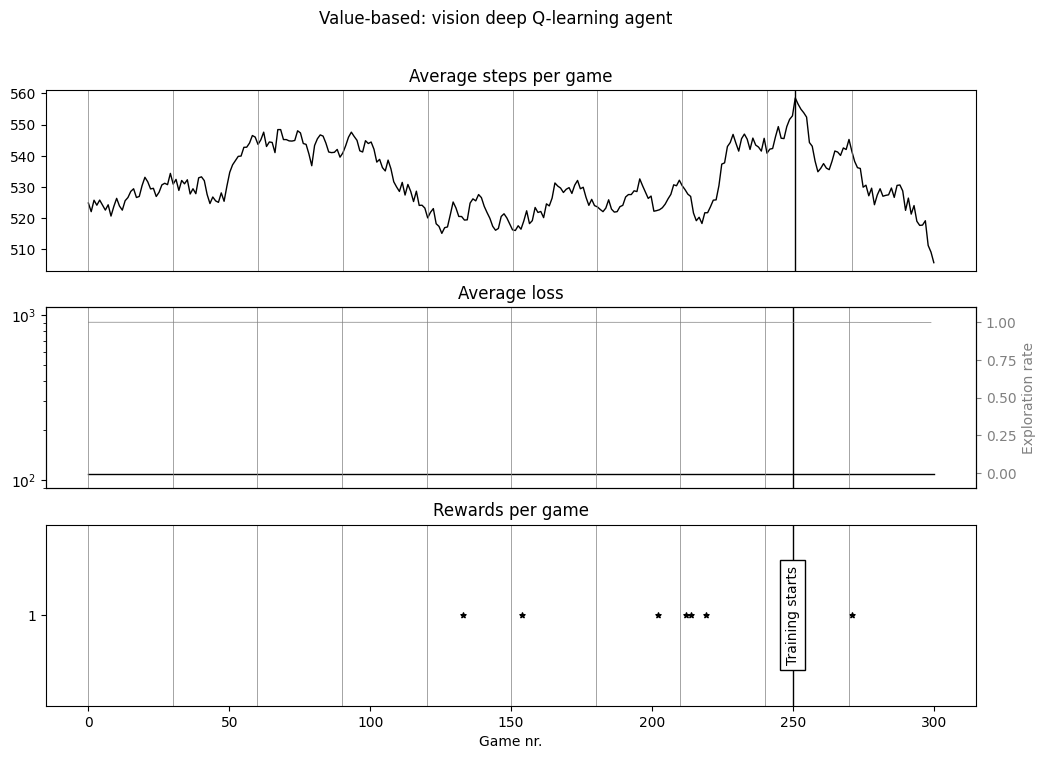

In [7]:
def moving_average(data, window_size=50):
    """Compute moving average with given window size of the data."""
    half_window = window_size // 2
    return [(data[max(0, i-half_window):min(len(data), i+half_window)]).mean() 
            for i in range(len(data))]

steps = moving_average(metrics["steps"])
losses = moving_average(metrics["losses"])
rewards = [val.item() if val > 0 else torch.nan for val in metrics["rewards"]]

fig, ax = plt.subplots(3, 1, figsize=(12, 8))
fig.suptitle("Value-based: vision deep Q-learning agent")

ax[0].plot(steps, color="black", linewidth=1)
ax[0].set_xticks([])
ax[0].set_title("Average steps per game")

ax[1].plot(torch.linspace(0, GAMES, len(losses)), losses, color="black", linewidth=1)
ax[1].set_yscale("log") if any(loss > 0 for loss in losses) else None
ax[1].set_xticks([])
ax[1].set_title("Average loss")

ax_2 = ax[1].twinx()
ax_2.plot(metrics["exploration"], color="gray", linewidth=0.5)
ax_2.set_ylabel("Exploration rate")
ax_2.yaxis.label.set_color('gray')
ax_2.set_ylim(-0.1, 1.1)
ax_2.tick_params(axis='y', colors='gray')

ax[2].scatter(range(len(rewards)), rewards, color="black", s=15, marker="*")
ticks = list(set(reward for reward in rewards if not torch.isnan(torch.tensor(reward))))
ax[2].set_yticks(ticks) if ticks else None
ax[2].set_xlim(ax[1].get_xlim())
ax[2].set_xlabel("Game nr.")
ax[2].set_title("Rewards per game")

for i in range(0, GAMES, GAMES // 10):
    ax[0].axvline(x=i, color='gray', linewidth=0.5)
    ax[1].axvline(x=i, color='gray', linewidth=0.5)
    ax[2].axvline(x=i, color='gray', linewidth=0.5)
    
if START_TRAINING_AT < GAMES:
    ax[0].axvline(x=START_TRAINING_AT, color='black', linewidth=1)
    ax[1].axvline(x=START_TRAINING_AT, color='black', linewidth=1)
    ax[2].axvline(x=START_TRAINING_AT, color='black', linewidth=1)
    ax[2].text(START_TRAINING_AT, 1, 'Training starts', 
               rotation=90, verticalalignment='center', horizontalalignment='center',
               bbox=dict(facecolor='white', alpha=1.0))

plt.savefig("./output/value-video-tetris.png")
plt.show()

##### In action

In [8]:
initial = torch.tensor(environment.reset()[0], dtype=torch.float32).view((1, 1, 1, 210, 160))
states = torch.cat([initial, initial, initial, initial], 
    dim=2
)

images = []
terminated = truncated = False
while not (terminated or truncated):
    action = value_agent.action(states)
    states = torch.zeros(value_agent.shape)

    for i in range(0, value_agent.shape[2]):
        new_state, _, terminated, truncated, _ = environment.step(action.item())
        new_state = torch.tensor(new_state, dtype=torch.float32).view((1, 1, 210, 160))
        states[0, 0, i] = new_state
    
    images.append(environment.render())
_ = imageio.mimsave('./output/value-video-tetris.gif', images, duration=50)

<img src="./output/value-video-tetris.gif" width="1000" height="1000" />

In [9]:
environment.close()